In [1]:
#import sys
#!{sys.executable} -m pip install gap_statistic

'{sys.executable}' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import pandas as pd
import numpy as np
import sys
import nltk
import re
import dalex as dx
#nltk.download()
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier,plot_importance
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.base import is_classifier
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.base import is_classifier
import numpy as np
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

C:\Conda-Julia\3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def validate(model, X, y, X_test=None, y_test=None, show_results=False):
    is_classification = is_classifier(model)
    use_cross_validation = X_test is None or y_test is None
        
    if use_cross_validation:
        if is_classification:
            scoring = "accuracy"
        else:
            scoring = "r2"
            
        val_results = cross_validate(model, X, y, scoring=scoring, n_jobs=-1, return_train_score=True, cv=3)
        train_score = np.mean(val_results["train_score"])
        test_score = np.mean(val_results["test_score"])
    else:           
        model.fit(X, y)
        pred_train = model.predict(X)
        pred_test = model.predict(X_test)
        
        if is_classification:
            train_score = metrics.accuracy_score(y, pred_train)
            test_score = metrics.accuracy_score(y_test, pred_test)
            
            if show_results:
                plot_confusion_matrix(y_test, pred_test)
        else:
            train_score = metrics.r2_score(y, pred_train)
            test_score = metrics.r2_score(y_test, pred_test)
            
            if show_results:
                raw_y_train = exp_y(y)
                raw_y_test = exp_y(y_test)
                raw_pred_train = exp_y(pred_train)
                raw_pred_test = exp_y(pred_test)
                
                plot_pred_data(raw_y_test, raw_pred_test)
                print(f"train MAE on y:", metrics.mean_absolute_error(raw_y_train, raw_pred_train))
                print(f"test MAE on y:", metrics.mean_absolute_error(raw_y_test, raw_pred_test))
            
    is_overfitted = train_score - test_score > 0.1
        
    if show_results:
        if is_classification:
            print(f"train acc:", train_score)
            print(f"test acc:", test_score)
        else:
            print(f"train r2 on log y:", train_score)
            print(f"test r2 on log y:", test_score)
            
        if is_overfitted:
            print("Overfitted")
        
    return test_score, is_overfitted    
    
    

   

In [3]:
data=pd.read_csv("fin_reviews2.csv")

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split



vector_columns = [col for col in data.columns if col.startswith('vector_')]
additional_columns = data.columns[:7].tolist()
X = data[vector_columns]
Y = data['stars']
additional_data = data[additional_columns]


X_train, X_test, Y_train, Y_test, additional_train, additional_test = train_test_split(
    X, Y, additional_data, test_size=0.1, random_state=42
)

train_data = pd.concat([additional_train.reset_index(drop=True), X_train.reset_index(drop=True), Y_train.reset_index(drop=True)], axis=1)
test_data = pd.concat([additional_test.reset_index(drop=True), X_test.reset_index(drop=True), Y_test.reset_index(drop=True)], axis=1)

print(train_data.head())
print(test_data.head())


   Column1  stars  useful  funny  cool  \
0  5598905    1.0       0      0     0   
1  1007105    5.0       0      0     0   
2  3246079    5.0       0      0     0   
3  6529475    3.0       1      3     0   
4  4420223    4.0       0      0     0   

                                                text  \
0  Worst ever bread sticks, they are my favorite ...   
1  My favorite fish market. The people are always...   
2  My husband and I enjoy going to this Applebee'...   
3  We went here and started to like it, it had ra...   
4  Very cozy place!! The staff was super friendly...   

                                          text_clean  vector_1  vector_2  \
0  worst ever bread stick favorite pizza place wo...  0.098454 -0.025144   
1  favorite fish market people always really nice...  0.091852  0.054103   
2  husband enjoy going applebees assistant manage... -0.038461  0.065825   
3  went started like rather modern interior forth...  0.133138 -0.026637   
4  cozy place staff super frie

In [6]:
train_data

,Column1,stars,useful,funny,cool,text,text_clean,vector_1,vector_2,vector_3,...,vector_292,vector_293,vector_294,vector_295,vector_296,vector_297,vector_298,vector_299,vector_300,stars
0,5598905,1.0,0,0,0,"Worst ever bread sticks, they are my favorite ...",worst ever bread stick favorite pizza place wo...,0.098454,-0.025144,0.121205,...,0.171603,-0.380297,-0.391959,0.046482,0.375932,-0.174133,0.028367,0.040346,-0.082905,1.0
1,1007105,5.0,0,0,0,My favorite fish market. The people are always...,favorite fish market people always really nice...,0.091852,0.054103,0.008347,...,0.195830,-0.539534,-0.382316,-0.238329,0.296614,0.062445,-0.092881,-0.125598,-0.050901,5.0
2,3246079,5.0,0,0,0,My husband and I enjoy going to this Applebee'...,husband enjoy going applebees assistant manage...,-0.038461,0.065825,0.254508,...,0.091770,-0.382636,-0.270933,-0.144074,0.195754,0.151536,-0.133550,-0.363998,0.118971,5.0
3,6529475,3.0,1,3,0,"We went here and started to like it, it had ra...",went started like rather modern interior forth...,0.133138,-0.026637,0.162337,...,0.032574,-0.456869,-0.367946,-0.104968,0.301826,0.072600,-0.168881,-0.163636,-0.042172,3.0
4,4420223,4.0,0,0,0,Very cozy place!! The staff was super friendly...,cozy place staff super friendly bar hopper fel...,0.120327,-0.161190,0.132224,...,-0.001809,-0.509260,-0.161263,-0.029938,0.292365,-0.116362,-0.062673,-0.104979,-0.134743,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53995,300065,5.0,1,0,0,I give it five stars for the fact that it has ...,give five star fact best sushi burg cheap real...,0.150327,-0.008751,0.142744,...,0.047478,-0.448136,-0.174750,-0.179253,0.286520,-0.034198,-0.174162,-0.104723,-0.120205,5.0
53996,2846083,2.0,0,0,0,We just finished our last dinner from Da Shin....,finished last dinner da shin hot sour soup nei...,0.129993,-0.067230,0.099126,...,0.146302,-0.431907,-0.240755,-0.092664,0.193530,-0.142460,-0.107174,-0.075016,-0.185508,2.0
53997,1022697,5.0,1,0,2,Absolutely delicious chicken & sides. And the ...,absolutely delicious chicken side customer ser...,0.066756,0.085969,0.076567,...,0.221247,-0.452954,-0.183405,-0.118807,0.305853,0.090025,-0.031727,-0.192105,-0.206235,5.0
53998,5250642,5.0,0,0,0,We tried Ozona out because Rusty Bellies in Ta...,tried ozona rusty belly tarpon extremely long ...,0.051158,0.017988,0.058684,...,0.191353,-0.434941,-0.204602,-0.099042,0.200853,0.002784,-0.051797,-0.068765,-0.077546,5.0


In [7]:
silhouette_scores = []
random_states = np.random.RandomState(888).randint(low=1, high=1000, size=3) 

for n_clusters in range(2, 6):
    temp_scores = []
    for state in random_states:
        kmeans = KMeans(n_clusters=n_clusters, random_state=state)
        kmeans.fit(X)
        predictions = kmeans.predict(X)
        score = silhouette_score(X, predictions)
        temp_scores.append(score)
    avg_score = np.mean(temp_scores)
    silhouette_scores.append(avg_score)

optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

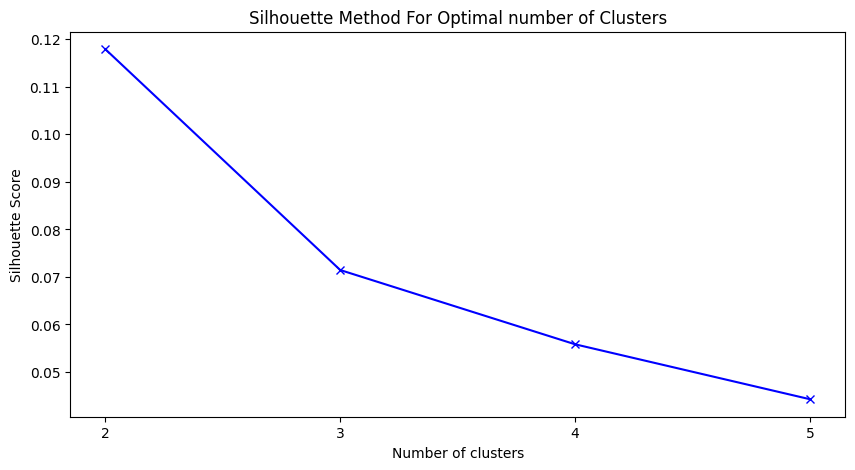

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(range(2, 6), silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal number of Clusters')
plt.xticks(range(2, 6))  
plt.show()

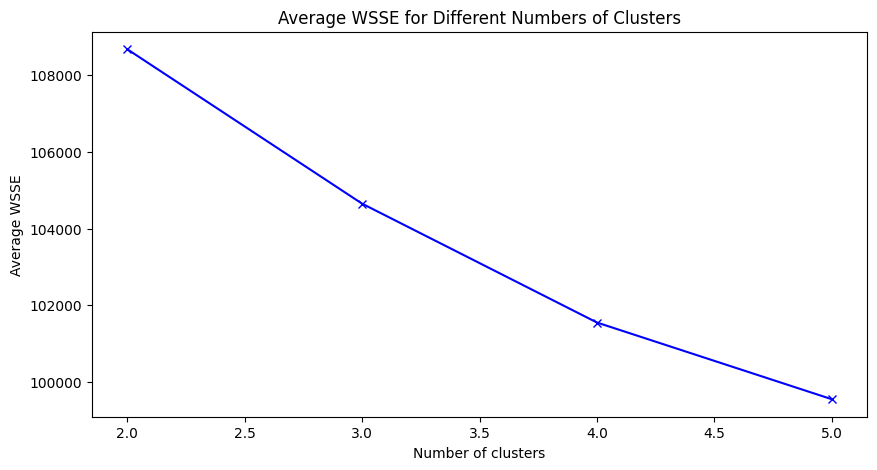

In [9]:

wsse = []   
kmax = 5
wsse_avg = []   

random_states = np.random.RandomState(888).randint(low=1, high=1000, size=10) 

for k in range(2, kmax+1):
    wsse = []
    for state in random_states:
        kmeans = KMeans(n_clusters=k, random_state=state).fit(X)
        wsse.append(kmeans.inertia_)
    wsse_avg.append(np.mean(wsse))

# Plotting
plt.figure(figsize=(10,5))
plt.plot(range(2, kmax+1), wsse_avg, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Average WSSE')
plt.title('Average WSSE for Different Numbers of Clusters')
plt.show()

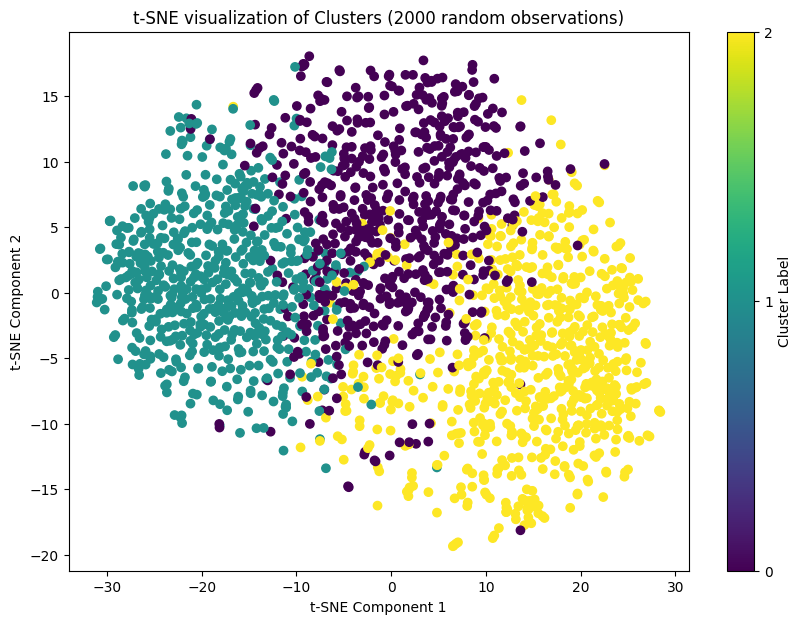

In [10]:

np.random.seed(42)

# Perform KMeans clustering on the entire dataset
kmeans = KMeans(n_clusters=3, random_state=0)
predictions = kmeans.fit_predict(X)

# Sample 2000 random observations from the dataset
sample_indices = np.random.choice(X.index, 2000, replace=False)
X_sampled = X.loc[sample_indices]
predictions_sampled = predictions[sample_indices]

# Use t-SNE to reduce the sampled data to 2 dimensions for visualization
tsne = TSNE(n_components=2, random_state=0, n_jobs=-1)
X_tsne = tsne.fit_transform(X_sampled)

# Plot the t-SNE transformed data with clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=predictions_sampled, cmap='viridis', marker='o')
plt.title('t-SNE visualization of Clusters (2000 random observations)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label', ticks=range(3))
plt.show()

In [7]:
kmeans = KMeans(n_clusters=3, random_state=0)
data['cluster'] = kmeans.fit_predict(data[vector_columns])

In [11]:
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer




kmeans = KMeans(n_clusters=3, random_state=0)
data['cluster'] = kmeans.fit_predict(data[vector_columns])

# Summary of numerical columns 1 to 4 for each cluster
summary = data.groupby('cluster')[data.columns[1:5]].describe()
print("Summary of numerical columns 1 to 4 for each cluster:")
print(summary)


vectorizer = CountVectorizer()
X_text = vectorizer.fit_transform(data['text_clean'])


df_text = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out())


df_text['cluster'] = data['cluster']


top_words = df_text.groupby('cluster').sum().T.apply(lambda x: x.nlargest(10).index.tolist())
print("\nTop 10 most common words in each cluster:")
print(top_words)


Summary of numerical columns 1 to 4 for each cluster:
           stars                                                useful  \
           count      mean       std  min  25%  50%  75%  max    count   
cluster                                                                  
0        19393.0  4.099108  1.190314  1.0  4.0  5.0  5.0  5.0  19393.0   
1        18571.0  3.963545  1.259970  1.0  3.0  4.0  5.0  5.0  18571.0   
2        22036.0  3.250635  1.729215  1.0  1.0  4.0  5.0  5.0  22036.0   

                   ... funny           cool                                \
             mean  ...   75%   max    count      mean       std  min  25%   
cluster            ...                                                      
0        0.824834  ...   0.0  31.0  19393.0  0.416645  1.477302  0.0  0.0   
1        1.122664  ...   0.0  82.0  18571.0  0.614183  2.524118  0.0  0.0   
2        1.560673  ...   0.0  80.0  22036.0  0.474859  1.926574  0.0  0.0   

                          
         50

In [12]:
pd.set_option('display.max_columns', None)
summary

stars                                                useful  \
           count      mean       std  min  25%  50%  75%  max    count   
cluster                                                                  
0        19393.0  4.099108  1.190314  1.0  4.0  5.0  5.0  5.0  19393.0   
1        18571.0  3.963545  1.259970  1.0  3.0  4.0  5.0  5.0  18571.0   
2        22036.0  3.250635  1.729215  1.0  1.0  4.0  5.0  5.0  22036.0   

                                                          funny            \
             mean       std  min  25%  50%  75%    max    count      mean   
cluster                                                                     
0        0.824834  1.952298  0.0  0.0  0.0  1.0   58.0  19393.0  0.217914   
1        1.122664  2.964505  0.0  0.0  0.0  1.0  143.0  18571.0  0.339400   
2        1.560673  3.323247  0.0  0.0  1.0  2.0  112.0  22036.0  0.399392   

                                                cool                           \
              std  min  25%  50%  75%   max    count      mean       std  min   
cluster                                                                         
0        0.898669  0.0  0.0  0.0  0.0  31.0  19393.0  0.416645  1.477302  0.0   
1        1.498263  0.0  0.0  0.0  0.0  82.0  18571.0  0.614183  2.524118  0.0   
2        1.558160  0.0  0.0  0.0  0.0  80.0  22036.0  0.474859  1.926574  0.0   

                               
         25%  50%  75%    max  
cluster                        
0        0.0  0.0  0.0   53.0  
1        0.0  0.0  1.0  143.0  
2        0.0  0.0  0.0   83.0

In [8]:
vector_columns = [col for col in data.columns if col.startswith('vector_')]
additional_columns = list(data.columns[:7]) + ['cluster']  # Add 'cluster' to the list
X = data[vector_columns]

additional_data = data[additional_columns]

Y = data['stars'].apply(lambda x: 0 if x > 3 else 1)


count_1 = Y.sum()
count_0 = len(Y) - count_1

print("Złe oceny", count_1)
print("Dobre oceny:", count_0)

X_train, X_test, Y_train, Y_test, additional_train, additional_test = train_test_split(
    X, Y, additional_data, test_size=0.1, random_state=42
)

Złe oceny 19816
Dobre oceny: 40184


In [26]:

k_values = range(1,15)  


cv_scores = []


for k in k_values:

    knn = KNeighborsClassifier(n_neighbors=k,n_jobs=-1)
    

    scores = cross_val_score(knn, X_train, Y_train, cv=5, scoring='accuracy')
    

    cv_scores.append(scores.mean())

optimal_k = k_values[np.argmax(cv_scores)]
best_score = max(cv_scores)

print("Optimal k:", optimal_k)
print("Best Cross-Validation Score:", best_score)


Optimal k: 14
Best Cross-Validation Score: 0.7963333333333333


In [28]:


best_knn = KNeighborsClassifier(n_neighbors=optimal_k)
best_knn.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=14)

In [31]:

Y_pred = best_knn.predict(X_test)


accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)


auc = roc_auc_score(Y_test, Y_pred)
print("AUC:", auc)


conf_matrix = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.7911666666666667
AUC: 0.7389844429895648
Confusion Matrix:
[[3580  412]
 [ 841 1167]]


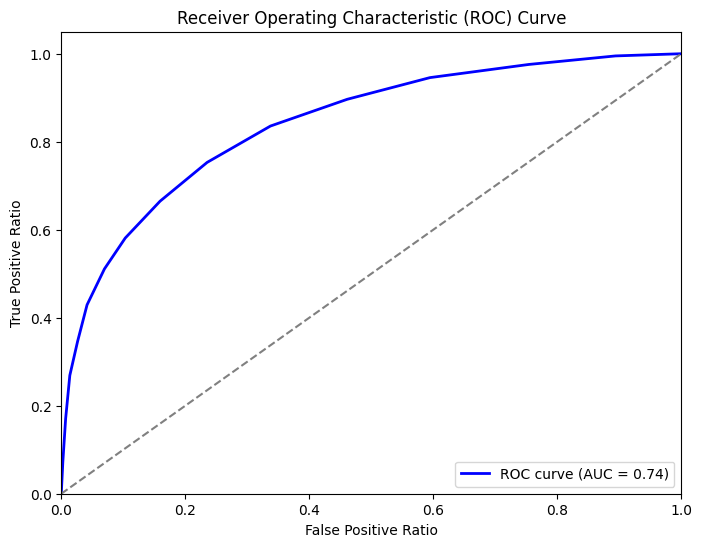

In [32]:



Y_prob = best_knn.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(Y_test, Y_prob)

# ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Ratio')
plt.ylabel('True Positive Ratio')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [12]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 1, 700)
    max_depth = trial.suggest_int('max_depth', 1,20)
    learning_rate=trial.suggest_float("learning_rate", 0.005, 0.1)
    
    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_jobs=-1,  
        random_state=120
    )
    
    score, is_overfitted = validate(model, X_train, Y_train)

    if is_overfitted:
        return 0
    else:
        return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500,n_jobs=-1)

[I 2024-06-02 22:24:26,782] A new study created in memory with name: no-name-acbc1bb3-b8ea-44a8-98d2-e6f4bb5437bc
[I 2024-06-02 22:42:26,622] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 128, 'max_depth': 11, 'learning_rate': 0.009939313332647654}. Best is trial 4 with value: 0.0.
[I 2024-06-02 22:43:31,255] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 7, 'max_depth': 11, 'learning_rate': 0.010234988336545039}. Best is trial 4 with value: 0.0.
[I 2024-06-02 23:28:32,882] Trial 8 finished with value: 0.8501481481481482 and parameters: {'n_estimators': 428, 'max_depth': 5, 'learning_rate': 0.03912634301812838}. Best is trial 8 with value: 0.8501481481481482.
[I 2024-06-02 23:32:41,182] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 458, 'max_depth': 13, 'learning_rate': 0.023735753731890026}. Best is trial 8 with value: 0.8501481481481482.


KeyboardInterrupt: 

In [13]:

print("Best trial:")
best_trial = study.best_trial

print(f"Value: {best_trial.value}")

print("Params: ")
for key, value in best_trial.params.items():
    print(f"{key}: {value}")


print("Best parameters: ", study.best_params)
print("Best value: ", study.best_value)

print("All trials: ")
for trial in study.trials:
    print(trial)

Best trial:
Value: 0.8501481481481482
Params: 
n_estimators: 428
max_depth: 5
learning_rate: 0.03912634301812838
Best parameters:  {'n_estimators': 428, 'max_depth': 5, 'learning_rate': 0.03912634301812838}
Best value:  0.8501481481481482
All trials: 
FrozenTrial(number=0, state=TrialState.RUNNING, values=None, datetime_start=datetime.datetime(2024, 6, 2, 22, 24, 26, 785529), datetime_complete=None, params={'n_estimators': 540, 'max_depth': 9, 'learning_rate': 0.051114064691916275}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=700, log=False, low=1, step=1), 'max_depth': IntDistribution(high=20, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.005, step=None)}, trial_id=0, value=None)
FrozenTrial(number=1, state=TrialState.COMPLETE, values=[0.0], datetime_start=datetime.datetime(2024, 6, 2, 22, 24, 26, 786537), datetime_complete=datetime.datetime(2024, 6, 2, 23, 32, 41, 181228), param

In [11]:
def objective(trial):
    n_estimators =  trial.suggest_int('n_estimators',1,700)
    max_depth=max_depth=trial.suggest_int('max_depth',1,30)   
    model= RandomForestClassifier(
         criterion="gini",
         random_state=120,
         max_depth=max_depth,
     
         n_estimators=n_estimators,
         
     )
    
    score, is_overfitted = validate(model, X_train,Y_train)

    if is_overfitted:
        return 0
    else:
        return score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500,n_jobs=-1)

[I 2024-06-03 00:04:24,322] A new study created in memory with name: no-name-1ecbc8c9-11f0-4ffb-9bac-edadf6d88704
[I 2024-06-03 00:06:36,410] Trial 0 finished with value: 0.6840370370370371 and parameters: {'n_estimators': 588, 'max_depth': 2}. Best is trial 0 with value: 0.6840370370370371.
[I 2024-06-03 00:08:44,716] Trial 4 finished with value: 0.7817592592592592 and parameters: {'n_estimators': 425, 'max_depth': 6}. Best is trial 4 with value: 0.7817592592592592.
[I 2024-06-03 00:09:03,621] Trial 11 finished with value: 0.770074074074074 and parameters: {'n_estimators': 288, 'max_depth': 5}. Best is trial 4 with value: 0.7817592592592592.
[I 2024-06-03 00:11:27,966] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 413, 'max_depth': 11}. Best is trial 4 with value: 0.7817592592592592.
[I 2024-06-03 00:12:33,415] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 201, 'max_depth': 14}. Best is trial 4 with value: 0.7817592592592592.
[I 2024-06-03 00:13

KeyboardInterrupt: 

In [12]:

print("Best trial:")
best_trial = study.best_trial

print(f"Value: {best_trial.value}")

print("Params: ")
for key, value in best_trial.params.items():
    print(f"{key}: {value}")

print("Best parameters: ", study.best_params)
print("Best value: ", study.best_value)

print("All trials: ")
for trial in study.trials:
    print(trial)

Best trial:
Value: 0.8042592592592593
Params: 
n_estimators: 650
max_depth: 9
Best parameters:  {'n_estimators': 650, 'max_depth': 9}
Best value:  0.8042592592592593
All trials: 
FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.6840370370370371], datetime_start=datetime.datetime(2024, 6, 3, 0, 4, 24, 325476), datetime_complete=datetime.datetime(2024, 6, 3, 0, 6, 36, 410718), params={'n_estimators': 588, 'max_depth': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=700, log=False, low=1, step=1), 'max_depth': IntDistribution(high=30, log=False, low=1, step=1)}, trial_id=0, value=None)
FrozenTrial(number=1, state=TrialState.COMPLETE, values=[0.0], datetime_start=datetime.datetime(2024, 6, 3, 0, 4, 24, 327474), datetime_complete=datetime.datetime(2024, 6, 3, 0, 22, 9, 364963), params={'n_estimators': 587, 'max_depth': 29}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistr

In [ ]:
def objective(trial):
    hidden_layer_sizes = tuple([trial.suggest_int(f'n_units_l{i}', 10, 200) for i in range(trial.suggest_int('n_layers', 1,6))])
    activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
    alpha = trial.suggest_float('alpha', 1e-5, 1e-2, log=True)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])
    max_iter = trial.suggest_int('max_iter', 200, 1000)
    
    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        alpha=alpha,
        learning_rate=learning_rate,
        max_iter=max_iter,
        random_state=120
    )
    
    score, is_overfitted = validate(model, X_train, Y_train)

    if is_overfitted:
        return 0
    else:
        return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500,n_jobs=-1)

[I 2024-06-03 00:45:28,493] A new study created in memory with name: no-name-83ecef6e-5f99-4597-ad26-834b33d1359f
[I 2024-06-03 00:45:55,439] Trial 10 finished with value: 0.6702222222222223 and parameters: {'n_layers': 6, 'n_units_l0': 140, 'n_units_l1': 124, 'n_units_l2': 51, 'n_units_l3': 197, 'n_units_l4': 127, 'n_units_l5': 78, 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 7.452330534969605e-05, 'learning_rate': 'adaptive', 'max_iter': 815}. Best is trial 10 with value: 0.6702222222222223.
[I 2024-06-03 00:51:08,301] Trial 9 finished with value: 0.6702222222222223 and parameters: {'n_layers': 3, 'n_units_l0': 149, 'n_units_l1': 43, 'n_units_l2': 184, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.003342708845885945, 'learning_rate': 'adaptive', 'max_iter': 593}. Best is trial 10 with value: 0.6702222222222223.
[I 2024-06-03 00:53:19,003] Trial 0 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 132, 'n_units_l1': 41, 'n_units_l2': 111, 'n_units_

In [ ]:
#[I 2024-06-03 00:42:37,181] Trial 9 finished with value: 0.8633518518518519 and parameters: {'n_layers': 3, 'n_units_l0': 27, 'n_units_l1': 160, 'n_units_l2': 39, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.00044571764339256306, 'learning_rate': 'adaptive', 'max_iter': 427}. Best is trial 9 with value: 0.8633518518518519.

In [14]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Create the models
xgb_model = XGBClassifier(
    n_estimators=428,
    max_depth=5,
    learning_rate=0.03912634301812838,
    n_jobs=-1,
    random_state=120
)

knn_model = KNeighborsClassifier(n_neighbors=14)

rf_model = RandomForestClassifier(
    criterion="gini",
    random_state=120,
    max_depth=9,
    n_estimators=650
)

mlp_model = MLPClassifier(
    hidden_layer_sizes=(27, 160, 39),
    activation='tanh',
    solver='sgd',
    alpha=0.00044571764339256306,
    learning_rate='adaptive',
    max_iter=427,
    random_state=120
)

# Split the test data into validation and final test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=120)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=120)

# List to store models and their names
models = [(xgb_model, "XGBoost"), (knn_model, "KNN"), (rf_model, "Random Forest"), (mlp_model, "MLP")]

# Dictionary to store model results
results = {}

# Train and evaluate models
for model, name in models:
    # Train the model
    model.fit(X_train, Y_train)
    
    # Save the trained model
    joblib.dump(model, f'{name}_model.joblib')
    
    # Predictions and probabilities
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    
    # Store the results
    results[name] = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'test_pred': Y_test_pred
    }
    
    # Print the results
    print(f"{name} - Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")

# Ensemble model using Logistic Regression on predictions
ensemble_train = np.column_stack([results[name]['test_pred'] for _, name in models])
ensemble_valid = np.column_stack([results[name]['test_pred'] for _, name in models])

# Train logistic regression on validation data
lr = LogisticRegression(random_state=120)
lr.fit(ensemble_valid, y_valid)

# Save the ensemble model
joblib.dump(lr, 'ensemble_model.joblib')

# Evaluate ensemble model
ensemble_test = np.column_stack([results[name]['test_pred'] for _, name in models])
Y_ensemble_pred = lr.predict(ensemble_test)
Y_ensemble_prob = lr.predict_proba(ensemble_test)[:, 1]

ensemble_accuracy = accuracy_score(Y_test, Y_ensemble_pred)
ensemble_auc = roc_auc_score(Y_test, Y_ensemble_prob)

# Print ensemble results
print(f"Ensemble Model - Test Accuracy: {ensemble_accuracy}, Test AUC: {ensemble_auc}")

# Plot ROC curve for ensemble model
fpr, tpr, _ = roc_curve(Y_test, Y_ensemble_prob)
plt.plot(fpr, tpr, label=f'Ensemble (AUC = {ensemble_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Ensemble Model')
plt.legend()
plt.show()



KeyboardInterrupt



In [13]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

Logistic Regression Ensemble Model Parameters:
Coefficient for XGBoost: -0.15606440671629088
Coefficient for KNN: -0.14047452463802482
Coefficient for Random Forest: -0.031503955614247924
Coefficient for MLP: 0.2576252141726185
Intercept: -0.7370150585880618
Ensemble Model - Test Accuracy: 0.6593333333333333, Test AUC: 0.37205276881310856


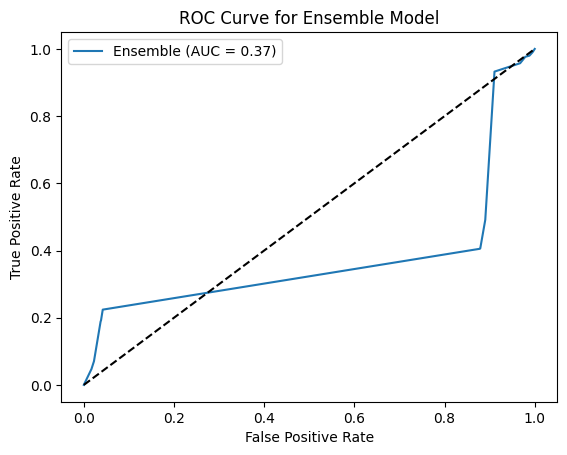

NameError: name 'ConfusionMatrixDisplay' is not defined

In [12]:

# Ensemble model using Logistic Regression on predictions
ensemble_train = np.column_stack([results[name]['test_pred'] for _, name in models])
ensemble_valid = np.column_stack([results[name]['test_pred'] for _, name in models])

lr = LogisticRegression(random_state=120)
lr.fit(ensemble_valid, Y_valid)
joblib.dump(lr, 'ensemble_model.joblib')

print("Logistic Regression Ensemble Model Parameters:")
for i, (model, name) in enumerate(models):
    print(f"Coefficient for {name}: {lr.coef_[0][i]}")
print(f"Intercept: {lr.intercept_[0]}")

ensemble_test = np.column_stack([results[name]['test_pred'] for _, name in models])
Y_ensemble_pred = lr.predict(ensemble_test)
Y_ensemble_prob = lr.predict_proba(ensemble_test)[:, 1]

ensemble_accuracy = accuracy_score(Y_test, Y_ensemble_pred)
ensemble_auc = roc_auc_score(Y_test, Y_ensemble_prob)
print(f"Ensemble Model - Test Accuracy: {ensemble_accuracy}, Test AUC: {ensemble_auc}")

fpr, tpr, _ = roc_curve(Y_test, Y_ensemble_prob)
plt.plot(fpr, tpr, label=f'Ensemble (AUC = {ensemble_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Ensemble Model')
plt.legend()
plt.show()

cm = confusion_matrix(Y_test, Y_ensemble_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix for Ensemble Model")
plt.show()

# Predict for rows 1 and 7 from the test set
rows_to_predict = test_data.iloc[[0, 6]]
X_rows_to_predict = rows_to_predict[vector_columns]

xgb_pred = xgb_model_loaded.predict(X_rows_to_predict)
knn_pred = knn_model_loaded.predict(X_rows_to_predict)
rf_pred = rf_model_loaded.predict(X_rows_to_predict)
mlp_pred = mlp_model_loaded.predict(X_rows_to_predict)

stacked_preds = np.column_stack([xgb_pred, knn_pred, rf_pred, mlp_pred])
ensemble_preds = ensemble_model_loaded.predict(stacked_preds)

# Extract text_clean column
text_clean = rows_to_predict['text_clean'].values

# Combine results into a DataFrame
results_df = pd.DataFrame({
    'text_clean': text_clean,
    'xgb_pred': xgb_pred,
    'knn_pred': knn_pred,
    'rf_pred': rf_pred,
    'mlp_pred': mlp_pred,
    'ensemble_pred': ensemble_preds
})

print(results_df)

In [11]:
def save_notebook():
    from IPython.display import display, Javascript
    display(Javascript("IPython.notebook.save_checkpoint();"))

In [ ]:
rows_to_predict = test_data.iloc[[0, 6]]
X_rows_to_predict = rows_to_predict[vector_columns]

xgb_pred = xgb_model_loaded.predict(X_rows_to_predict)
knn_pred = knn_model_loaded.predict(X_rows_to_predict)
rf_pred = rf_model_loaded.predict(X_rows_to_predict)
mlp_pred = mlp_model_loaded.predict(X_rows_to_predict)

stacked_preds = np.column_stack([xgb_pred, knn_pred, rf_pred, mlp_pred])
ensemble_preds = ensemble_model_loaded.predict(stacked_preds)

# Extract text_clean column
text_clean = rows_to_predict['text_clean'].values

# Combine results into a DataFrame
results_df = pd.DataFrame({
    'text_clean': text_clean,
    'xgb_pred': xgb_pred,
    'knn_pred': knn_pred,
    'rf_pred': rf_pred,
    'mlp_pred': mlp_pred,
    'ensemble_pred': ensemble_preds
})

print(results_df)

In [16]:
xgb_model_loaded = joblib.load('XGBoost_model.joblib')
knn_model_loaded = joblib.load('KNN_model.joblib')
rf_model_loaded = joblib.load('Random Forest_model.joblib')
mlp_model_loaded = joblib.load('MLP_model.joblib')
ensemble_model_loaded = joblib.load('ensemble_model.joblib')


In [ ]:
[1,3,11,59995]

In [41]:

# Predict for rows 1 and 7 from the test set
rows_to_predict = data.iloc[[1,3,11,59995,59999]]
X_rows_to_predict = rows_to_predict[vector_columns]

xgb_pred = xgb_model_loaded.predict(X_rows_to_predict)
knn_pred = knn_model_loaded.predict(X_rows_to_predict)
rf_pred = rf_model_loaded.predict(X_rows_to_predict)
mlp_pred = mlp_model_loaded.predict(X_rows_to_predict)

stacked_preds = np.column_stack([xgb_pred, knn_pred, rf_pred, mlp_pred])
ensemble_preds = ensemble_model_loaded.predict(stacked_preds)

# Extract text_clean column
text_clean = rows_to_predict['text_clean'].values

# Combine results into a DataFrame
results_df = pd.DataFrame({
    'text_clean': text_clean,
    'xgb_pred': xgb_pred,
    'knn_pred': knn_pred,
    'rf_pred': rf_pred,
    'mlp_pred': mlp_pred,
    'ensemble_pred': ensemble_preds
})

results_df

,text_clean,xgb_pred,knn_pred,rf_pred,mlp_pred,ensemble_pred
0,went breakfast club spur moment today saturday...,0,0,0,0,0
1,confirmed pick 8 didnt truck pay confirmation ...,1,1,1,1,0
2,wow food amazing ordered twin chimichanga simp...,0,0,0,0,0
3,mouse floor mouse running table mouse climbing...,1,1,1,1,0
4,hotel aesthetically beautiful comment wall thi...,1,1,1,1,0


In [42]:
X_rows_to_predict = rows_to_predict[vector_columns]

xgb_pred = xgb_model_loaded.predict(X_rows_to_predict)
knn_pred = knn_model_loaded.predict(X_rows_to_predict)
rf_pred = rf_model_loaded.predict(X_rows_to_predict)
mlp_pred = mlp_model_loaded.predict(X_rows_to_predict)

stacked_preds = np.column_stack([xgb_pred, knn_pred, rf_pred, mlp_pred])
ensemble_preds = ensemble_model_loaded.predict(stacked_preds)

# Extract text_clean and stars columns
text_clean = rows_to_predict['text_clean'].values
stars = rows_to_predict['stars'].values

# Combine results into a DataFrame
results_df = pd.DataFrame({
    'text_clean': text_clean,
    'stars': stars,
    'xgb_pred': xgb_pred,
    'knn_pred': knn_pred,
    'rf_pred': rf_pred,
    'mlp_pred': mlp_pred,
    'ensemble_pred': ensemble_preds
})

results_df

,text_clean,stars,xgb_pred,knn_pred,rf_pred,mlp_pred,ensemble_pred
0,went breakfast club spur moment today saturday...,5.0,0,0,0,0,0
1,confirmed pick 8 didnt truck pay confirmation ...,1.0,1,1,1,1,0
2,wow food amazing ordered twin chimichanga simp...,4.0,0,0,0,0,0
3,mouse floor mouse running table mouse climbing...,1.0,1,1,1,1,0
4,hotel aesthetically beautiful comment wall thi...,3.0,1,1,1,1,0


In [40]:
data

,Column1,stars,useful,funny,cool,text,text_clean,vector_1,vector_2,vector_3,...,vector_292,vector_293,vector_294,vector_295,vector_296,vector_297,vector_298,vector_299,vector_300,cluster
0,809618,5.0,4,3,4,History...how could it get any less than five ...,historyhow could get le five star really thoug...,0.131096,0.001429,0.075301,...,0.003065,-0.426825,-0.289135,-0.026856,0.142469,0.132441,-0.319291,-0.201572,0.134387,2
1,31940,5.0,0,0,0,Went to The Breakfast Club on the spur of the ...,went breakfast club spur moment today saturday...,0.150379,-0.069865,-0.071607,...,0.094031,-0.428173,-0.276871,-0.044246,0.299566,0.021896,-0.079414,-0.041776,-0.067177,1
2,5880842,3.0,0,0,0,Is this place still open 24 hours? Ever since ...,place still open 24 hour ever since got rid th...,0.092041,-0.038479,0.135359,...,0.166113,-0.457723,-0.372023,0.026655,0.166335,-0.109283,-0.263470,-0.111787,-0.049703,0
3,6658047,1.0,0,0,0,Had confirmed pick up at 8 am. They didn't hav...,confirmed pick 8 didnt truck pay confirmation ...,0.029624,0.007045,0.168391,...,0.077662,-0.473395,-0.315763,-0.052474,0.103837,0.126269,-0.177747,-0.212313,0.084790,2
4,6977881,5.0,0,0,0,Absolutely loved it. This place was so good st...,absolutely loved place good still thinking goo...,0.130850,-0.086237,0.080631,...,0.106493,-0.571607,-0.283986,0.006422,0.425590,-0.017609,-0.113858,-0.195258,-0.113796,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,5256586,1.0,3,0,0,"Mice on the floor, mice running under the tabl...",mouse floor mouse running table mouse climbing...,0.006604,0.016781,0.156272,...,-0.149072,-0.320032,-0.276446,0.102704,0.314303,-0.070666,0.039680,-0.050335,-0.047447,1
59996,5084279,4.0,0,0,0,First visit was a good experience. Juicy flavo...,first visit good experience juicy flavorful me...,0.104296,0.010705,0.106332,...,0.081685,-0.493888,-0.085218,-0.255372,0.274259,0.016849,-0.291361,-0.231652,0.091708,0
59997,2772718,5.0,1,0,0,These guys are awesome the only place in Tucso...,guy awesome place tucson let touch watch alway...,0.095666,-0.031013,0.132251,...,0.115885,-0.348299,-0.350015,-0.145530,0.139884,0.288249,-0.126819,-0.424871,0.011907,2
59998,3954261,4.0,0,2,0,Who knew we could engage in Portland delight r...,knew could engage portland delight right reno ...,-0.009282,0.056382,0.099271,...,0.008653,-0.350598,-0.096513,-0.019006,0.238933,-0.082309,-0.157825,-0.052349,0.010275,1


In [ ]:
import os
#os.system('shutdown /s /t 120')
